In [2]:
import numpy as np
import time
import cantera as ct

print(f"Running Cantera version: {ct.__version__}")

Running Cantera version: 3.0.0


In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ["png"]
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
#plt.style.use("seaborn-pastel")

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.dpi"] = 120

C:\Users\aetor\AppData\Local\Temp\ipykernel_39036\2735788229.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
eta = 0.42
power = 120e6  # W
PCI = 45e6  # J/kg

m_dot_air = 240  # kg/s
m_dot_fuel = power/(eta*PCI)  # kg/s
print(f"Fuel mass flow rate: {m_dot_fuel:.3f} kg/s")

FuelAirRatio = m_dot_fuel/m_dot_air
print(f"Fuel-air ratio: {FuelAirRatio:.3f}")

FuelAirRatio_stoich = 1*(8*12+18)/(12.5*(2*16+3.76*14))
print(f"Stoichiometric fuel-air ratio: {FuelAirRatio_stoich:.3f}")

phi = FuelAirRatio/FuelAirRatio_stoich
print(f"Equivalence ratio: {phi:.3f}")

Fuel mass flow rate: 6.349 kg/s
Fuel-air ratio: 0.026
Stoichiometric fuel-air ratio: 0.108
Equivalence ratio: 0.246


In [4]:
gas = ct.Solution("Jerzembeck.yaml")
gas.TP = 800, 30*ct.one_atm
gas.set_equivalence_ratio(phi, "IXC8H18", "O2:1.0, N2:3.76")
gas.equilibrate("HP")
print(f"Equilibrium temperature: {gas.T:.1f} K")
print("Mole fractions: CO: {:.3f}ppm, NO: {:.3f}ppm".format(gas["CO"].X[0]*10e6, gas["NO"].X[0]*10e6))


Equilibrium temperature: 1397.8 K
Mole fractions: CO: 0.140ppm, NO: 6166.168ppm


In [5]:
gas1 = ct.Solution('Jerzembeck.yaml')

# Create a Reservoir for the inlet, set to a methane/air mixture at a specified
# equivalence ratio
equiv_ratio =  phi
gas1.TP = 800.0, 30*ct.one_atm
gas1.set_equivalence_ratio(equiv_ratio, 'IXC8H18', 'O2:1.0, N2:3.76')
inlet = ct.Reservoir(gas1)

# Create the combustor, and fill it initially with a mixture consisting of the
# equilibrium products of the inlet mixture. This state corresponds to the state
# the reactor would reach with infinite residence time, and thus provides a good
# initial condition from which to reach a steady-state solution on the reacting
# branch.
gas1.equilibrate('HP')
combustor = ct.IdealGasReactor(gas1)
combustor.volume = 0.4
# combustor.volume = 1000000000

# Create a reservoir for the exhaust
exhaust = ct.Reservoir(gas1)

inlet_fuel = ct.MassFlowController(inlet, combustor, mdot=m_dot_fuel)
inlet_air = ct.MassFlowController(inlet, combustor, mdot=m_dot_air)

# A PressureController has a baseline mass flow rate matching the 'primary'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
#outlet = ct.PressureController(combustor, exhaust, primary=inlet_air, K=0.01)
outlet = ct.PressureController(combustor, exhaust, master=inlet_air, K=0.01)

# the simulation only contains one reactor
sim = ct.ReactorNet([combustor])
sim.advance_to_steady_state()

print("temperature: {:.1f} K".format(combustor.T))
residence_time = combustor.mass/outlet.mass_flow_rate
print(f"Residence time: {residence_time:.3f} s")
X_CO = combustor.thermo['CO'].X[0]
X_NO = combustor.thermo['NO'].X[0]
print("CO mass fraction: {:.3f}".format(X_CO*10e6))
print("NO mass fraction: {:.3f}".format(X_NO*10e6))


temperature: 1366.7 K
Residence time: 0.012 s
CO mass fraction: 32763.370
NO mass fraction: 0.539


C:\Users\aetor\AppData\Local\Temp\ipykernel_39036\292673999.py:31: DeprecationWarning: PressureController: The 'master' keyword argument is deprecated; use 'primary' instead.
  outlet = ct.PressureController(combustor, exhaust, master=inlet_air, K=0.01)


7.

In [6]:

gas1 = ct.Solution('Jerzembeck.yaml')

Vec_Power = np.arange(100e6,360e6,10e6)
Vec_tres = np.zeros(len(Vec_Power))
Vec_X_CO = np.zeros(len(Vec_Power))
Vec_X_NO = np.zeros(len(Vec_Power))
Vec_X_CO2 = np.zeros(len(Vec_Power))
Vec_Temp = np.zeros(len(Vec_Power))
Vec_Phi = np.zeros(len(Vec_Power))
Vec_mdotfuel = np.zeros(len(Vec_Power))


eta = 0.42
PCI = 45e6  # J/kg
m_dot_air = 240  # kg/s

for Pow in Vec_Power: 
    m_dot_fuel = Pow/(eta*PCI)  # kg/s
    print(f"Fuel mass flow rate: {m_dot_fuel:.3f} kg/s")
    FuelAirRatio = m_dot_fuel/m_dot_air
    FuelAirRatio_stoich = 1*(8*12+18)/(12.5*(2*16+3.76*14))
    phi = FuelAirRatio/FuelAirRatio_stoich
    print(f"Equivalence ratio: {phi:.3f}")
    gas1.TP = 800.0, 30*ct.one_atm
    gas1.set_equivalence_ratio(phi, 'IXC8H18', 'O2:1.0, N2:3.76')
    inlet = ct.Reservoir(gas1)
    gas1.equilibrate('HP')

    combustor = ct.IdealGasReactor(gas1)
    combustor.volume = 0.4
    exhaust = ct.Reservoir(gas1)
    inlet_fuel = ct.MassFlowController(inlet, combustor, mdot=m_dot_fuel)
    inlet_air = ct.MassFlowController(inlet, combustor, mdot=m_dot_air)
    #outlet = ct.PressureController(combustor, exhaust, primary=inlet_air, K=0.01)
    outlet = ct.PressureController(combustor, exhaust, master=inlet_air, K=0.01)

    sim = ct.ReactorNet([combustor])
    sim.advance_to_steady_state()

    residence_time = combustor.mass/outlet.mass_flow_rate
    X_CO = combustor.thermo['CO'].X[0]
    X_NO = combustor.thermo['NO'].X[0]
    X_CO2 = combustor.thermo['CO2'].X[0]
    Vec_tres[Vec_Power==Pow] = residence_time
    Vec_X_CO[Vec_Power==Pow] = X_CO
    Vec_X_NO[Vec_Power==Pow] = X_NO
    Vec_X_CO2[Vec_Power==Pow] = X_CO2
    Vec_Temp[Vec_Power==Pow] = combustor.T
    Vec_Phi[Vec_Power==Pow] = phi
    Vec_mdotfuel[Vec_Power==Pow] = m_dot_fuel
    

Fuel mass flow rate: 5.291 kg/s
Equivalence ratio: 0.205
Fuel mass flow rate: 5.820 kg/s
Equivalence ratio: 0.225
Fuel mass flow rate: 6.349 kg/s
Equivalence ratio: 0.246
Fuel mass flow rate: 6.878 kg/s
Equivalence ratio: 0.266
Fuel mass flow rate: 7.407 kg/s
Equivalence ratio: 0.286


C:\Users\aetor\AppData\Local\Temp\ipykernel_39036\3450528770.py:35: DeprecationWarning: PressureController: The 'master' keyword argument is deprecated; use 'primary' instead.
  outlet = ct.PressureController(combustor, exhaust, master=inlet_air, K=0.01)


Fuel mass flow rate: 7.937 kg/s
Equivalence ratio: 0.307
Fuel mass flow rate: 8.466 kg/s
Equivalence ratio: 0.327
Fuel mass flow rate: 8.995 kg/s
Equivalence ratio: 0.348
Fuel mass flow rate: 9.524 kg/s
Equivalence ratio: 0.368
Fuel mass flow rate: 10.053 kg/s
Equivalence ratio: 0.389
Fuel mass flow rate: 10.582 kg/s
Equivalence ratio: 0.409
Fuel mass flow rate: 11.111 kg/s
Equivalence ratio: 0.430
Fuel mass flow rate: 11.640 kg/s
Equivalence ratio: 0.450
Fuel mass flow rate: 12.169 kg/s
Equivalence ratio: 0.471
Fuel mass flow rate: 12.698 kg/s
Equivalence ratio: 0.491
Fuel mass flow rate: 13.228 kg/s
Equivalence ratio: 0.512
Fuel mass flow rate: 13.757 kg/s
Equivalence ratio: 0.532
Fuel mass flow rate: 14.286 kg/s
Equivalence ratio: 0.552
Fuel mass flow rate: 14.815 kg/s
Equivalence ratio: 0.573
Fuel mass flow rate: 15.344 kg/s
Equivalence ratio: 0.593
Fuel mass flow rate: 15.873 kg/s
Equivalence ratio: 0.614
Fuel mass flow rate: 16.402 kg/s
Equivalence ratio: 0.634
Fuel mass flow rat

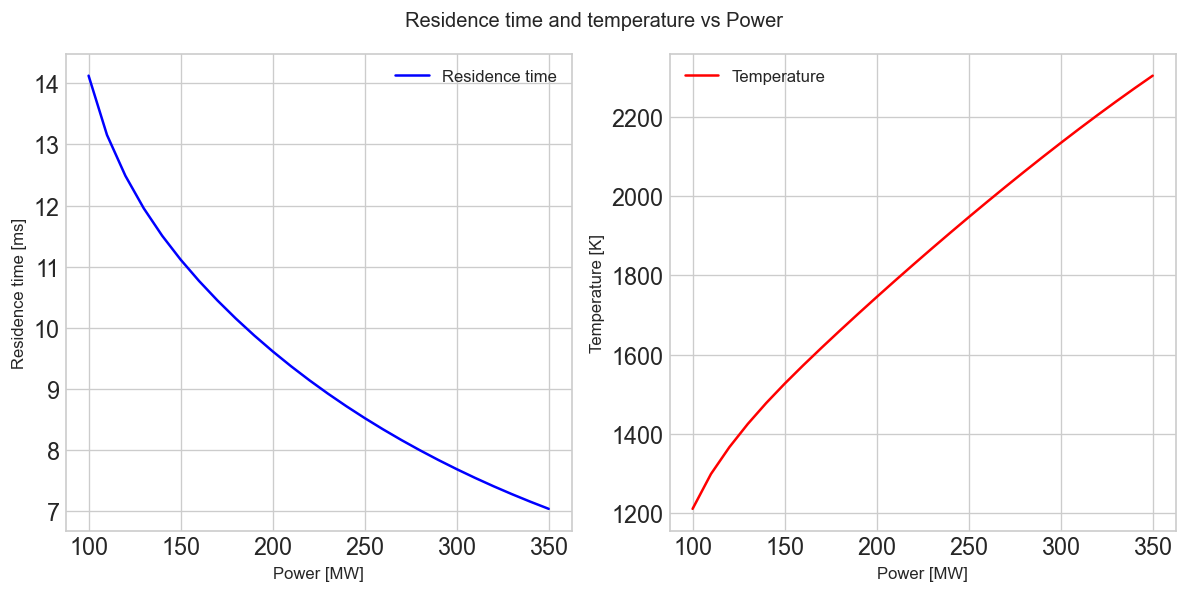

In [7]:
fig, axs = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 1]},figsize=(10,5))
axs[0].plot(Vec_Power*1e-6,Vec_tres*1e3,label='Residence time',color='blue')
axs[0].set_xlabel('Power [MW]',fontsize=10)
axs[0].set_ylabel('Residence time [ms]',fontsize=10)
axs[0].legend()

axs[1].plot(Vec_Power*1e-6,Vec_Temp,label='Temperature',color='red')
axs[1].set_xlabel('Power [MW]',fontsize=10)
axs[1].set_ylabel('Temperature [K]',fontsize=10)
axs[1].legend()


fig.suptitle('Residence time and temperature vs Power',fontsize=12)
fig.tight_layout()


plt.show()



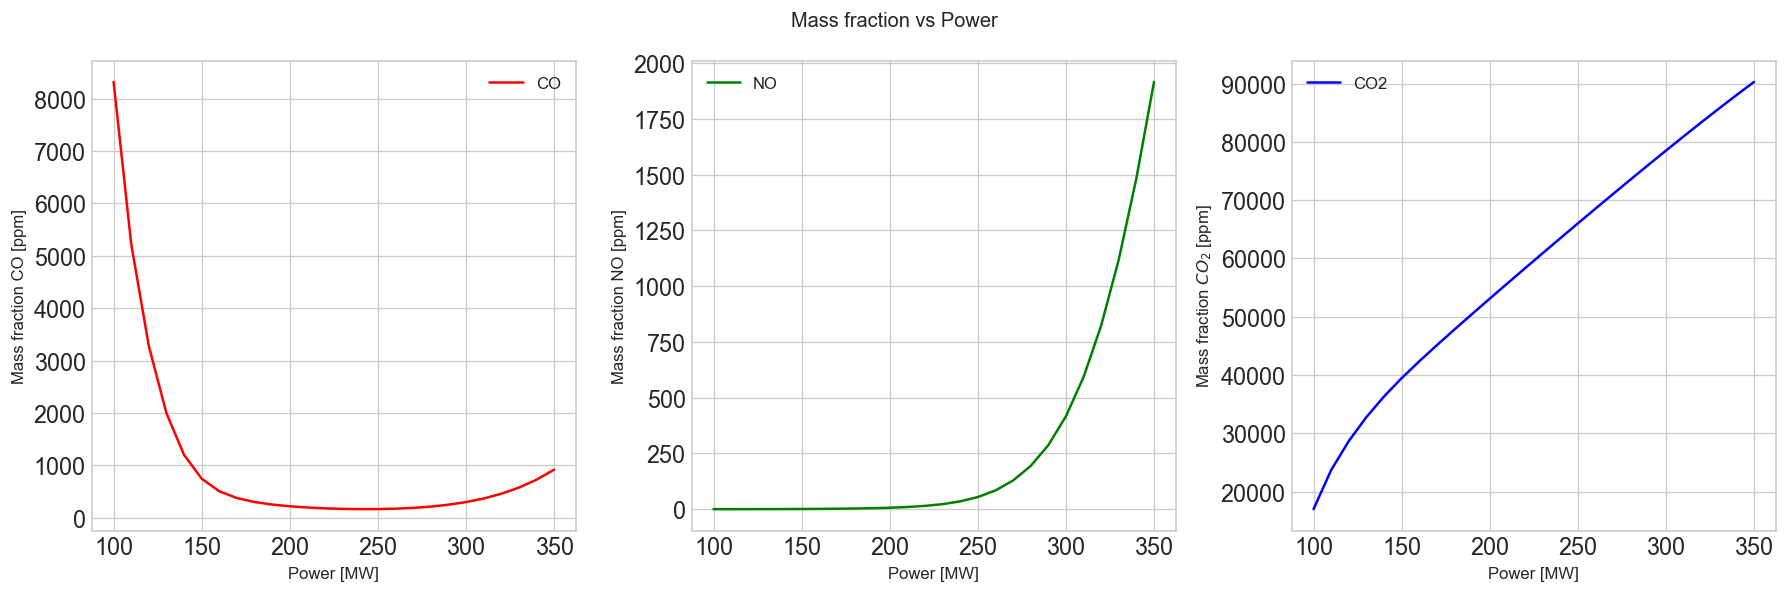

In [8]:
fig, axs = plt.subplots(1,3,figsize=(15,5),gridspec_kw={'width_ratios': [1, 1, 1]})

axs[0].plot(Vec_Power*1e-6,Vec_X_CO*1e6,label='CO',color='red')
axs[0].set_xlabel('Power [MW]',fontsize=10)
axs[0].set_ylabel('Mass fraction CO [ppm]',fontsize=10)
axs[0].legend()

axs[1].plot(Vec_Power*1e-6,Vec_X_NO*1e6,label='NO',color='green')
axs[1].set_xlabel('Power [MW]',fontsize=10)
axs[1].set_ylabel('Mass fraction NO [ppm]',fontsize=10)
axs[1].legend()

axs[2].plot(Vec_Power*1e-6,Vec_X_CO2*1e6,label='CO2',color='blue')
axs[2].set_xlabel('Power [MW]',fontsize=10)
axs[2].set_ylabel(r'Mass fraction $CO_2$ [ppm]',fontsize=10)
axs[2].legend()

fig.suptitle('Mass fraction vs Power',fontsize=12)
fig.tight_layout()
plt.show()

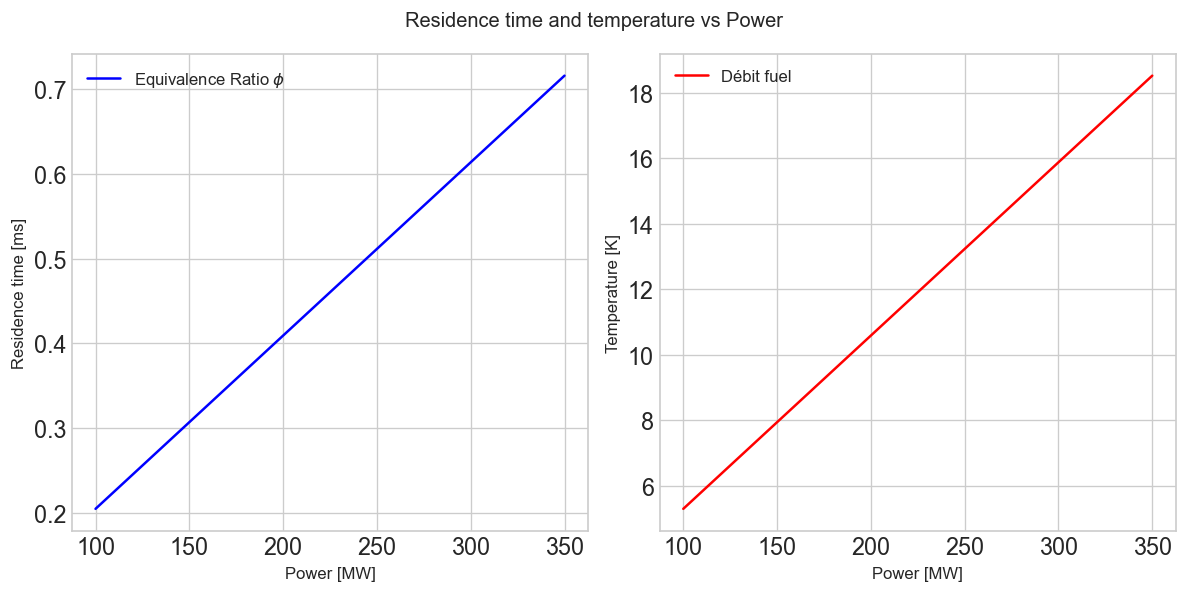

In [9]:
fig, axs = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 1]},figsize=(10,5))
axs[0].plot(Vec_Power*1e-6,Vec_Phi,label=r"Equivalence Ratio $\phi$",color='blue')
axs[0].set_xlabel('Power [MW]',fontsize=10)
axs[0].set_ylabel('Residence time [ms]',fontsize=10)
axs[0].legend()

axs[1].plot(Vec_Power*1e-6,Vec_mdotfuel,label='Débit fuel',color='red')
axs[1].set_xlabel('Power [MW]',fontsize=10)
axs[1].set_ylabel('Temperature [K]',fontsize=10)
axs[1].legend()


fig.suptitle('Residence time and temperature vs Power',fontsize=12)
fig.tight_layout()


plt.show()